# NYC Taxi Spatial Notebook

The New York Green Cab datasets have long been interesting large datasets to both observe the behavior of NYCers and test performance.  However, the dataset has long been known to have noise and bad data within it.  Also, we haven't really been able to analyze how NYCers travel between their 5 boroughs and surrounding areas.  

`cuSpatial`, the GPU-accelerated RAPIDS spatial library, can now allow everyone to quickly both clean the data to analyze travel between only the 5 boroughs as well as let us dive deeper into the interborough behavior of NYCers.

In this notebook, we will primarily demonstrate 
- `cuSpatial`'s `Point in Polygon` (PIP) and `Window Points` (WP) capabilities 
- how to use them effectively in a workflow alongside other RAPIDS libraries, like `cudf` and `cuXFilter`.  

We'll also show:
- how polygons data work in cuSpatial with features, rings, and coordinates
- how to analyze specific features in polygons with PIP
- a small CPU comparison
- how to visualize your data spatial data with cuXFilter
- methods of cleaning spatial data with cuSpatial and cuXFilter

In [1]:
import cuspatial
import geopandas as gpd
import cudf
from numba import cuda
import numpy as np

try:
    import matplotlib
except ImportError:
    !conda install -c conda-forge -y matplotlib
    import matplotlib

## Add Notebook Ports
Before you go on your click-fest through this notebook, **please add your notebook server's URL and port**
- local server, use: `127.0.0.1:<port>`
- remote server (Paperspace, AWS, GCP, Azure, etc), use `<notebook ip address>:<notebook server port>`

If you don't do this correctly, the **notebook's visualiztion will FAIL!!**

In [4]:
#for cuXfilter in Paperspace, the URL can be pulled from the instance's environment values
import os
nid = os.environ['PAPERSPACE_NOTEBOOK_ID']
cid = os.environ['PAPERSPACE_CLUSTER_ID']
url = 'https://'+nid+'.'+cid+'.paperspacegradient.com/'
port = '8888'         # set this to your notebook server's jupyterlab port

# Get your data

In [5]:
%%time
NYC_boroughs = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON')
NYC_boroughs.to_file('NYC_boroughs.shp')
NYC_gpu = cuspatial.read_polygon_shapefile('NYC_boroughs.shp')

CPU times: user 473 ms, sys: 40.5 ms, total: 514 ms
Wall time: 1.2 s


# Let's check out the shape file

cuSpatial geometry uses a packed format. In this object, `NYC_gpu`, the first GPU-array in the tuple contains the feature positions `f_pos`. `Feature 0` is the first 24 rings, `Feature 1` is the set of rings from index 24-28, and so forth.

`r_pos` are the ring positions of each feature. `Ring 0` is the first 12 coordinate pairs, `Ring 1` is the coordinate pairs from index 12-511, and so forth.

Finally the `DataFrame` at position `2` in `NYC_gpu` are the 75519 coordinates used in all 5 features, and the 106 rings that compose them.


In [6]:
print(NYC_boroughs.boro_name) # take note of Borough names for later
print(NYC_gpu)

0        Manhattan
1            Bronx
2         Brooklyn
3           Queens
4    Staten Island
Name: boro_name, dtype: object
(0      0
1     34
2     60
3     88
4    109
Name: f_pos, dtype: int32, 0          0
1         14
2         19
3         24
4         29
       ...  
108    58747
109    74602
110    74649
111    74658
112    74716
Name: r_pos, Length: 113, dtype: int32,                x          y
0     -74.010928  40.684491
1     -74.009533  40.685342
2     -74.008601  40.685910
3     -74.008513  40.685963
4     -74.008425  40.686016
...          ...        ...
83570 -74.081652  40.648424
83571 -74.081866  40.648373
83572 -74.082046  40.648308
83573 -74.082124  40.648278
83574 -74.082213  40.648280

[83575 rows x 2 columns])


In [7]:
t = NYC_gpu[2].iloc[511:522]
print(t)

             x          y
511 -73.966365  40.719056
512 -73.964351  40.720404
513 -73.964593  40.720545
514 -73.964683  40.720470
515 -73.964398  40.720297
516 -73.964351  40.720404
517 -73.963998  40.720938
518 -73.964894  40.721475
519 -73.965049  40.721357
520 -73.964088  40.720756
521 -73.963998  40.720938


You can see above the 11 vertices that make up `Feature 0`, `Ring 1`.

## Working with Polygons
Let's look at and dive into the elements of the read shapefile using cuSpatial

In [8]:
print("Polygon Bounds:" , NYC_gpu[0]) # upper bound of the rings that make up the polygon (feature)
print("Last Vertex:" , NYC_gpu[1]) # this is the position of the last vertex in each ring

# You can get the lon/lat by 
print("Longitude: ", NYC_gpu[2]['x']) # prints lon
print("Latitude: " , NYC_gpu[2]['y']) # prints lat
      
NYC_gpu[2]['x'] = NYC_gpu[2]['x']
NYC_gpu[2]['y'] = NYC_gpu[2]['y']

Polygon Bounds: 0      0
1     34
2     60
3     88
4    109
Name: f_pos, dtype: int32
Last Vertex: 0          0
1         14
2         19
3         24
4         29
       ...  
108    58747
109    74602
110    74649
111    74658
112    74716
Name: r_pos, Length: 113, dtype: int32
Longitude:  0       -74.010928
1       -74.009533
2       -74.008601
3       -74.008513
4       -74.008425
           ...    
83570   -74.081652
83571   -74.081866
83572   -74.082046
83573   -74.082124
83574   -74.082213
Name: x, Length: 83575, dtype: float64
Latitude:  0        40.684491
1        40.685342
2        40.685910
3        40.685963
4        40.686016
           ...    
83570    40.648424
83571    40.648373
83572    40.648308
83573    40.648278
83574    40.648280
Name: y, Length: 83575, dtype: float64


In [9]:
NYC_gpu[1].head(25) #this set of rings are NYC_gpu[1][0] (the first polygon). This data is packed.  

0       0
1      14
2      19
3      24
4      29
5      87
6      93
7     390
8     397
9     405
10    416
11    421
12    427
13    457
14    469
15    476
16    484
17    492
18    503
19    512
20    517
21    522
22    530
23    555
24    579
Name: r_pos, dtype: int32

## Taxi Data
Let's import the taxi data.  Newer years have pickup/drop off location ids that you would have to cross correlate.  Older years, like 2015 give you a lon/lat values.  We'll be using those ideas

In [10]:
taxi2016 = cudf.read_csv("https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2016-01.csv")
#taxi2016 = cudf.read_csv("taxi2016.csv")
print(taxi2016.dtypes)

VendorID                   int64
lpep_pickup_datetime      object
Lpep_dropoff_datetime     object
Store_and_fwd_flag        object
RateCodeID                 int64
Pickup_longitude         float64
Pickup_latitude          float64
Dropoff_longitude        float64
Dropoff_latitude         float64
Passenger_count            int64
Trip_distance            float64
Fare_amount              float64
Extra                    float64
MTA_tax                  float64
Tip_amount               float64
Tolls_amount             float64
Ehail_fee                   int8
improvement_surcharge    float64
Total_amount             float64
Payment_type               int64
Trip_type                float64
dtype: object


In [11]:
taxi2016.count()

VendorID                 1445285
lpep_pickup_datetime     1445285
Lpep_dropoff_datetime    1445285
Store_and_fwd_flag       1445285
RateCodeID               1445285
Pickup_longitude         1445285
Pickup_latitude          1445285
Dropoff_longitude        1445285
Dropoff_latitude         1445285
Passenger_count          1445285
Trip_distance            1445285
Fare_amount              1445285
Extra                    1445285
MTA_tax                  1445285
Tip_amount               1445285
Tolls_amount             1445285
Ehail_fee                      0
improvement_surcharge    1445285
Total_amount             1445285
Payment_type             1445285
Trip_type                1445283
dtype: int64

## GPU Point-In-Polygon

- 12m pickup locations
- 12m dropoff locations
- 5 borough features
- 107 borough polygons
- 75518 borough coordinates

Now that we've collected the set of pickup locations and dropoff locations, we can use `cuSpatial.point_in_polygon_bitmap` to quickly determine which pickups and drop-offs occur in each borough. That is, 5 boroughs composed of a total of 107 polygons.

In [12]:
taxi2016['dropoff_latitude']= taxi2016['Dropoff_latitude'].fillna(0.000000)
taxi2016['dropoff_longitude']= taxi2016['Dropoff_longitude'].fillna(0.000000)

In [13]:
taxi2016['Dropoff_latitude'].value_counts()

0.000000     2329
40.805157     134
40.805119     128
40.805126     127
40.805134     126
             ... 
40.863567       1
40.874508       1
41.148003       1
40.911270       1
40.589149       1
Name: Dropoff_latitude, Length: 80270, dtype: int32

In [14]:
taxi2016['Dropoff_longitude'].value_counts()

 0.000000     2329
-73.952766     270
-73.952728     244
-73.952690     238
-73.939110     237
              ... 
-74.029106       1
-74.325378       1
-73.733223       1
-74.157265       1
-73.796791       1
Name: Dropoff_longitude, Length: 40389, dtype: int32

In [15]:
%%time

NYC_gpu[0].index = ["Bronx", "Staten Island", "Manhattan", "Brooklyn", "Queens"]

pickups = cuspatial.point_in_polygon(taxi2016['Pickup_longitude'] , taxi2016['Pickup_latitude'], NYC_gpu[0], NYC_gpu[1], NYC_gpu[2]['x'], NYC_gpu[2]['y'])
dropoffs = cuspatial.point_in_polygon(taxi2016['Dropoff_longitude'] , taxi2016['Dropoff_latitude'], NYC_gpu[0], NYC_gpu[1], NYC_gpu[2]['x'], NYC_gpu[2]['y'])

CPU times: user 4.64 s, sys: 1.71 s, total: 6.35 s
Wall time: 6.37 s


In [16]:
pickups.head()

,Bronx,Staten Island,Manhattan,Brooklyn,Queens
0,False,False,True,False,False
1,False,False,True,False,False
2,False,False,True,False,False
3,False,False,True,False,False
4,False,False,True,False,False


In [17]:
dropoffs.head()

,Bronx,Staten Island,Manhattan,Brooklyn,Queens
0,False,False,True,False,False
1,False,False,False,True,False
2,False,False,True,False,False
3,False,False,True,False,False
4,False,False,True,False,False


We just computed point in polygon for 1.4 million points against 75.5k other points, twice. I'm sure you'll agree that that's really fast. Simply computing the pairwise distance between all 2.8m points and the 75.5k polygon coordinates is `2800000*75500=211 billion` comparisons. We're **NOT going to compare full CPU times**.  

# Making the Spatial data useful for the other RAPIDS libraries

Now that we've identify the polygon membership status of every one of our 12m points, lets add that information back into our original dataframe. From that point we could easily save the data permanently for future use, or, run further analytics using cuML, as we'll continue this current example, load it into cuXFilter for visualization.

In [18]:
taxi2016['pickup_borough'] = 'external'
taxi2016['pickup_borough'][pickups['Bronx']] = 'Bronx'
taxi2016['pickup_borough'][pickups['Staten Island']] = 'Staten Island'
taxi2016['pickup_borough'][pickups['Brooklyn']] = 'Brooklyn'
taxi2016['pickup_borough'][pickups['Queens']] = 'Queens'
taxi2016['pickup_borough'][pickups['Manhattan']] = 'Manhattan'
taxi2016['dropoff_borough'] = 'external'
taxi2016['dropoff_borough'][dropoffs['Bronx']] = 'Bronx'
taxi2016['dropoff_borough'][dropoffs['Staten Island']] = 'Staten Island'
taxi2016['dropoff_borough'][dropoffs['Brooklyn']] = 'Brooklyn'
taxi2016['dropoff_borough'][dropoffs['Queens']] = 'Queens'
taxi2016['dropoff_borough'][dropoffs['Manhattan']] = 'Manhattan'
name_map = {"external": 5, "Bronx": 0 , "Staten Island": 1, "Brooklyn": 3, "Queens": 4, "Manhattan": 2}
taxi2016['pickup_borough_integer'] = taxi2016['pickup_borough'].map(name_map)
taxi2016['dropoff_borough_integer'] = taxi2016['dropoff_borough'].map(name_map)

The following code block does what the above code block does. The above is much simpler. Am I missing a detail, or can we use the above?

## Add the outputs to your taxi dataframe

In [19]:
taxi2016.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,improvement_surcharge,Total_amount,Payment_type,Trip_type,dropoff_latitude,dropoff_longitude,pickup_borough,dropoff_borough,pickup_borough_integer,dropoff_borough_integer
0,2,2016-01-01 00:29:24,2016-01-01 00:39:36,N,1,-73.928642,40.680611,-73.924278,40.698044,1,...,0.3,11.16,1,1.0,40.698044,-73.924278,Manhattan,Manhattan,2,2
1,2,2016-01-01 00:19:39,2016-01-01 00:39:18,N,1,-73.952675,40.723175,-73.923920,40.761379,1,...,0.3,16.80,2,1.0,40.761379,-73.923920,Manhattan,Brooklyn,2,3
2,2,2016-01-01 00:19:33,2016-01-01 00:39:48,N,1,-73.971611,40.676105,-74.013161,40.646072,1,...,0.3,22.25,1,1.0,40.646072,-74.013161,Manhattan,Manhattan,2,2
3,2,2016-01-01 00:22:12,2016-01-01 00:38:32,N,1,-73.989502,40.669579,-74.000648,40.689034,1,...,0.3,14.80,2,1.0,40.689034,-74.000648,Manhattan,Manhattan,2,2
4,2,2016-01-01 00:24:01,2016-01-01 00:39:22,N,1,-73.964729,40.682854,-73.940720,40.663013,1,...,0.3,13.30,2,1.0,40.663013,-73.940720,Manhattan,Manhattan,2,2


In [20]:
taxi2016['all_within_boroughs'] = (
   (taxi2016['pickup_borough'] != 'external')
 & (taxi2016['dropoff_borough'] != 'external')
)

In [21]:
taxi2016.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Total_amount,Payment_type,Trip_type,dropoff_latitude,dropoff_longitude,pickup_borough,dropoff_borough,pickup_borough_integer,dropoff_borough_integer,all_within_boroughs
0,2,2016-01-01 00:29:24,2016-01-01 00:39:36,N,1,-73.928642,40.680611,-73.924278,40.698044,1,...,11.16,1,1.0,40.698044,-73.924278,Manhattan,Manhattan,2,2,True
1,2,2016-01-01 00:19:39,2016-01-01 00:39:18,N,1,-73.952675,40.723175,-73.923920,40.761379,1,...,16.80,2,1.0,40.761379,-73.923920,Manhattan,Brooklyn,2,3,True
2,2,2016-01-01 00:19:33,2016-01-01 00:39:48,N,1,-73.971611,40.676105,-74.013161,40.646072,1,...,22.25,1,1.0,40.646072,-74.013161,Manhattan,Manhattan,2,2,True
3,2,2016-01-01 00:22:12,2016-01-01 00:38:32,N,1,-73.989502,40.669579,-74.000648,40.689034,1,...,14.80,2,1.0,40.689034,-74.000648,Manhattan,Manhattan,2,2,True
4,2,2016-01-01 00:24:01,2016-01-01 00:39:22,N,1,-73.964729,40.682854,-73.940720,40.663013,1,...,13.30,2,1.0,40.663013,-73.940720,Manhattan,Manhattan,2,2,True


In [22]:
taxi2016['dropoff_borough'].value_counts()

Bronx            491791
Manhattan        470169
Brooklyn         384989
Staten Island     91078
external           6810
Queens              448
Name: dropoff_borough, dtype: int32

In [23]:
taxi2016['pickup_borough'].value_counts()

Manhattan        569463
Bronx            407381
Brooklyn         393267
Staten Island     71186
external           3705
Queens              283
Name: pickup_borough, dtype: int32

In [24]:
taxi2016['all_within_boroughs'].value_counts()

True     1436331
False       8954
Name: all_within_boroughs, dtype: int32

In [25]:
taxi2016['interborough']= (taxi2016[[]].assign(interborough=taxi2016.pickup_borough != taxi2016.dropoff_borough))

In [26]:
taxi2016['interborough'].value_counts()

False    1208196
True      237089
Name: interborough, dtype: int32

# Cleaning the Data
Now that we have some great analytics, let's do what we came here to do: get a clean, 5 borough only dataset with no drop offs in the middle of the water. There are two ways to clean the data, made possible by using cuspatial: 
    1. through cuspatial (no visualization required)
    1. through cuxfilter (has awesome visualizations, but it is required to create an output)
    
## Cleaning with cuspatial 
With cuSpatial, we can easily query the data on `all_within_boroughs` or where `pickup_borough` and `dropoff_borough` are `!=0`.  Since we created `all_within_boroughs` mostly for an easy option two, and you'd probably not do that in your spatial workflow, we'll show how to do it the latter way.  

The `True` and `False` values don't equal up to our full dataset numbers. The remainder, "None" type, will contain the extra-borough transportation as well as the dirty data.  Good to look at with interest, but outside of our scope.  If you want to clean this data as well, you'll been boundary maps of th rest of the TriState area.  

In [27]:
taxi2016['lpep_pickup_datetime']=taxi2016['lpep_pickup_datetime'].astype('datetime64[s]')
taxi2016['lpep_dropoff_datetime']=taxi2016['Lpep_dropoff_datetime'].astype('datetime64[s]')
taxi2016['day_of_the_month']=taxi2016['lpep_pickup_datetime'].dt.day
taxi2016['time_of_the_day']= taxi2016['lpep_pickup_datetime'].dt.hour

In [28]:
taxi_cuS_cleaned = taxi2016[
    (
        (taxi2016['pickup_borough'] != 'external')
      & (taxi2016['dropoff_borough'] != 'external')
    )
]

In [29]:
taxi_cuS_cleaned.head(50)

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,dropoff_longitude,pickup_borough,dropoff_borough,pickup_borough_integer,dropoff_borough_integer,all_within_boroughs,interborough,lpep_dropoff_datetime,day_of_the_month,time_of_the_day
0,2,2016-01-01 00:29:24,2016-01-01 00:39:36,N,1,-73.928642,40.680611,-73.924278,40.698044,1,...,-73.924278,Manhattan,Manhattan,2,2,True,False,2016-01-01 00:39:36,1,0
1,2,2016-01-01 00:19:39,2016-01-01 00:39:18,N,1,-73.952675,40.723175,-73.923920,40.761379,1,...,-73.923920,Manhattan,Brooklyn,2,3,True,True,2016-01-01 00:39:18,1,0
2,2,2016-01-01 00:19:33,2016-01-01 00:39:48,N,1,-73.971611,40.676105,-74.013161,40.646072,1,...,-74.013161,Manhattan,Manhattan,2,2,True,False,2016-01-01 00:39:48,1,0
3,2,2016-01-01 00:22:12,2016-01-01 00:38:32,N,1,-73.989502,40.669579,-74.000648,40.689034,1,...,-74.000648,Manhattan,Manhattan,2,2,True,False,2016-01-01 00:38:32,1,0
4,2,2016-01-01 00:24:01,2016-01-01 00:39:22,N,1,-73.964729,40.682854,-73.940720,40.663013,1,...,-73.940720,Manhattan,Manhattan,2,2,True,False,2016-01-01 00:39:22,1,0
5,2,2016-01-01 00:32:59,2016-01-01 00:39:35,N,1,-73.891144,40.746456,-73.867744,40.742111,1,...,-73.867744,Brooklyn,Brooklyn,3,3,True,False,2016-01-01 00:39:35,1,0
6,2,2016-01-01 00:34:42,2016-01-01 00:39:21,N,1,-73.896675,40.746197,-73.886192,40.745689,1,...,-73.886192,Brooklyn,Brooklyn,3,3,True,False,2016-01-01 00:39:21,1,0
7,2,2016-01-01 00:31:23,2016-01-01 00:39:36,N,1,-73.953354,40.803558,-73.949150,40.794121,1,...,-73.949150,Bronx,Bronx,0,0,True,False,2016-01-01 00:39:36,1,0
8,2,2016-01-01 00:24:40,2016-01-01 00:39:52,N,1,-73.994064,40.702816,-73.971573,40.679726,1,...,-73.971573,Manhattan,Manhattan,2,2,True,False,2016-01-01 00:39:52,1,0
9,2,2016-01-01 00:28:59,2016-01-01 00:39:23,N,1,-73.914131,40.756641,-73.917549,40.739658,1,...,-73.917549,Brooklyn,Brooklyn,3,3,True,False,2016-01-01 00:39:23,1,0


## Let's Get Visual!

In [30]:
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import Hot
from pyproj import Proj, Transformer

def makeXfilter(x, y):
    temp= cudf.DataFrame()
    transform_4326_to_3857 = Transformer.from_crs('epsg:4326', 'epsg:3857')
    temp['x'], temp['y'] = transform_4326_to_3857.transform(
                                                x.to_array(), y.to_array()
                                            )
    print(temp.head())
    return temp.x, temp.y

              x             y
0 -8.229699e+06  4.965345e+06
1 -8.232374e+06  4.971595e+06
2 -8.234482e+06  4.964684e+06
3 -8.236474e+06  4.963726e+06
4 -8.233716e+06  4.965675e+06
              x             y
0 -8.229213e+06  4.967905e+06
1 -8.229173e+06  4.977209e+06
2 -8.239107e+06  4.960277e+06
3 -8.237715e+06  4.966582e+06
4 -8.231043e+06  4.962763e+06


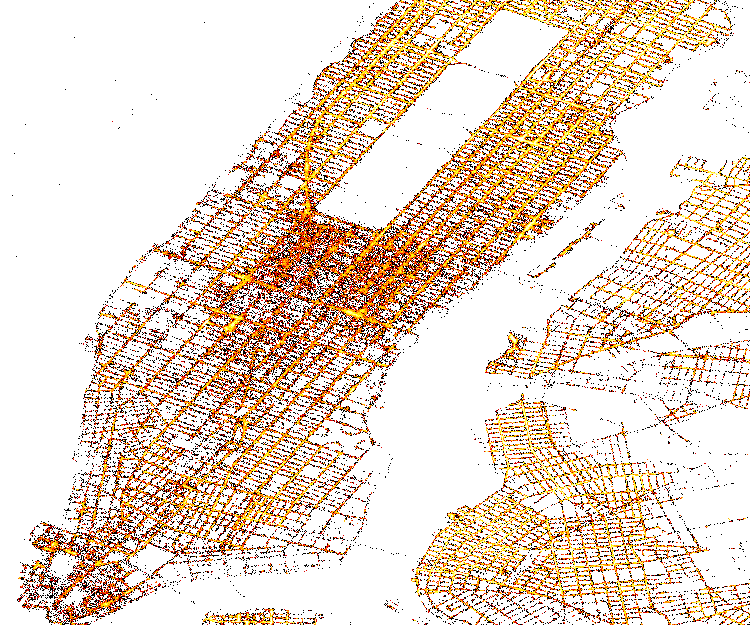

In [31]:
taxi2016['pu_x'], taxi2016['pu_y'] = makeXfilter(taxi2016['Pickup_latitude'], taxi2016['Pickup_longitude'])
taxi2016['do_x'], taxi2016['do_y'] = makeXfilter(taxi2016['Dropoff_latitude'],taxi2016['Dropoff_longitude'])
cvs = ds.Canvas(plot_width=750, plot_height=625, x_range=(-8239910.23,-8229529.24), y_range=(4968481.34,4983152.92)) # Create canvas
agg = cvs.points(taxi2016, 'do_x', 'do_y', ds.count('Passenger_count')) # Perform aggregation
img = tf.shade(agg, cmap=Hot, how='eq_hist') # Produce image from aggregation

img # Display image

              x             y
0 -8.229699e+06  4.965345e+06
1 -8.232374e+06  4.971595e+06
2 -8.234482e+06  4.964684e+06
3 -8.236474e+06  4.963726e+06
4 -8.233716e+06  4.965675e+06
              x             y
0 -8.229213e+06  4.967905e+06
1 -8.229173e+06  4.977209e+06
2 -8.239107e+06  4.960277e+06
3 -8.237715e+06  4.966582e+06
4 -8.231043e+06  4.962763e+06


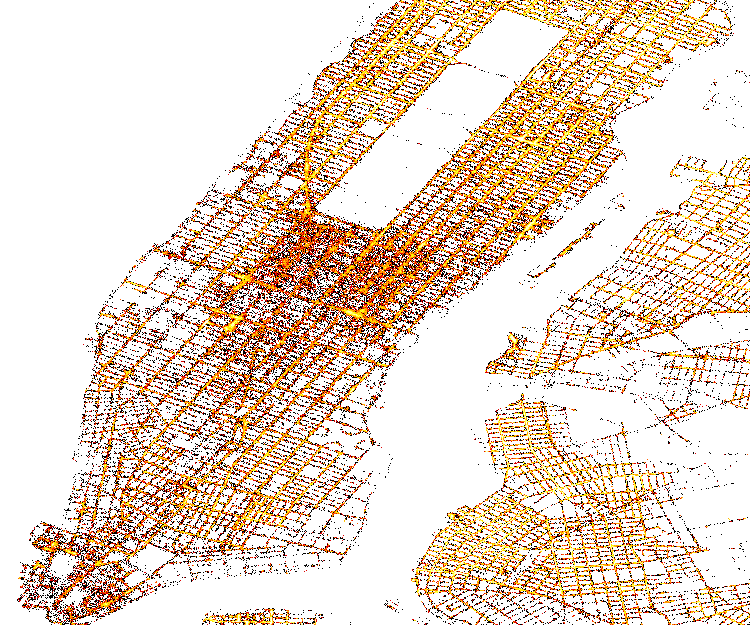

In [32]:
taxi_cuS_cleaned['pu_x'], taxi_cuS_cleaned['pu_y'] = makeXfilter(taxi_cuS_cleaned['Pickup_latitude'], taxi_cuS_cleaned['Pickup_longitude'])
taxi_cuS_cleaned['do_x'], taxi_cuS_cleaned['do_y'] = makeXfilter(taxi_cuS_cleaned['Dropoff_latitude'],taxi_cuS_cleaned['Dropoff_longitude'])
cvs = ds.Canvas(plot_width=750, plot_height=625, x_range=(-8239910.23,-8229529.24), y_range=(4968481.34,4983152.92)) # Create canvas
agg = cvs.points(taxi_cuS_cleaned, 'do_x', 'do_y', ds.count('Passenger_count')) # Perform aggregation
img = tf.shade(agg, cmap=Hot, how='eq_hist') # Produce image from aggregation

img # Display image

## Cleaning using cuXFilter
(You may remember me from other notebooks like...)  

First, we're going to have a little fun with this.  All those new parameters we created will be put to use.  We're going to an interactive visualization on the whole `taxi2016` dataset.  In the end you'll be able to see:
1. original data pickups
1. original data dropoffs
1. cuSpatial cleaned pickups
1. cuSpatial cleaned dropoffs
1. original data and cleaned intraborough pickups
1. original data and cleaned intraborough dropoffs
1. original data and cleaned interborough pickups
1. original data and cleaned interborough dropoffs
1. and more!

To do this, we're going to 
1. convert the pickup and drop off coordinates from lat/lon to EPSG:4326 format
1. prep the bokeh server to show a background map to overlay our data
1. create some charts to plot pickup and drop off points
1. create some more charts to help filter the data by parameters of interest, like 
 1. pickup borough by borough
 1. dropoff borough by borough
 1. Whether the trip was interborough
 1. and a quick filter on whether or not the whole trip was within NYC's 5 boroughs (yes, the "easy button" cleaning filter)

In [33]:
import cuxfilter
from bokeh import palettes
from cuxfilter.layouts import double_feature

In [34]:
from pyproj import Proj, Transformer

taxi2016['pu_x'], taxi2016['pu_y'] = makeXfilter(taxi2016['Pickup_latitude'], taxi2016['Pickup_longitude'])
taxi2016['do_x'], taxi2016['do_y'] = makeXfilter(taxi2016['Dropoff_latitude'],taxi2016['Dropoff_longitude'])
cux = cuxfilter.DataFrame.from_dataframe(taxi2016)

              x             y
0 -8.229699e+06  4.965345e+06
1 -8.232374e+06  4.971595e+06
2 -8.234482e+06  4.964684e+06
3 -8.236474e+06  4.963726e+06
4 -8.233716e+06  4.965675e+06
              x             y
0 -8.229213e+06  4.967905e+06
1 -8.229173e+06  4.977209e+06
2 -8.239107e+06  4.960277e+06
3 -8.237715e+06  4.966582e+06
4 -8.231043e+06  4.962763e+06


In [35]:
from bokeh.tile_providers import get_provider as gp
tile_provider = gp('CARTODBPOSITRON')

### Create your charts and launch the dashboard

In [36]:
label_map = {
    0:"Manhattan",
    1:"Bronx",
    2:"Brooklyn",
    3:"Queens",
    4:"Staten Island",
    5:"external"
}
chart0 = cuxfilter.charts.scatter(x='pu_x',
                                      y='pu_y',
                                      title='NYC Taxi Pickups',
                                      aggregate_fn='count',
                                      tile_provider=tile_provider, x_range=(-8267428.97,-8207328.23), y_range=(4935861.67,5000548.55))
chart1 = cuxfilter.charts.scatter(x='do_x',
                                      y='do_y',
                                      title='NYC Taxi Dropoffs',
                                      aggregate_fn='count',
                                      tile_provider=tile_provider, x_range=(-8267428.97,-8207328.23), y_range=(4935861.67,5000548.55))
chart2 = cuxfilter.charts.multi_select('pickup_borough_integer', label_map=label_map)
chart3 = cuxfilter.charts.multi_select('dropoff_borough_integer', label_map=label_map)
chart4 = cuxfilter.charts.multi_select('day_of_the_month')
chart5 = cuxfilter.charts.multi_select('time_of_the_day')

In [37]:
d = cux.dashboard([chart0, chart1], sidebar=[chart2, chart3, chart4, chart5], layout=cuxfilter.layouts.feature_and_base, theme=cuxfilter.themes.dark, title= 'NYC TAXI DATASET')
d.show(url+':'+port)

Dashboard running at port 38417


Row(sizing_mode='stretch_both')
    [0] Button(button_type='success', name='open cuxfilter d..., sizing_mode='stretch_both')

Fun things to notice:

- Unlike Yellow Taxi Cabs, [green taxis are not allowed to pick up below 110th St West and 96th St east.  If they do, they are fined.](https://nypost.com/2014/06/10/tlc-cracking-down-on-drivers-who-illegally-pick-up-street-hails/)  Do you see any illegal pick ups?

f you've seen the yellow cab visualizations, 
- If you compare the two, you'll notice that Green Taxis go deeper into Brooklyn, Bronx and Queens.

# WARNING!
Before you stop the data viz, please 
1. select all boroughs that aren't `external` in `pickup_borough_integer` and `dropoff_borough_integer`.  This will give you a cleaned dataset
1. Then, run the next cell to export the data in the visualizations as a dataframe.  

This will give you a similar result to the `taxi_cuS_cleaned` dataset.  Then, we'll stop the visualization and compare the two datasets for similarity, just to prove that they are the same.

In [ ]:
taxi_cuX_cleaned = d.export()

final query pickup_borough_integer in (0,1,2,3,4) and dropoff_borough_integer in (0,1,2,3,4)


In [ ]:
taxi_cuX_cleaned.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,dropoff_borough_integer,all_within_boroughs,interborough,lpep_dropoff_datetime,day_of_the_month,time_of_the_day,pu_x,pu_y,do_x,do_y
0,2,2016-01-01 00:29:24,2016-01-01 00:39:36,N,1,-73.928642,40.680611,-73.924278,40.698044,1,...,2,True,False,2016-01-01 00:39:36,1,0,-8.229699e+06,4.965345e+06,-8.229213e+06,4.967905e+06
1,2,2016-01-01 00:19:39,2016-01-01 00:39:18,N,1,-73.952675,40.723175,-73.923920,40.761379,1,...,3,True,True,2016-01-01 00:39:18,1,0,-8.232374e+06,4.971595e+06,-8.229173e+06,4.977209e+06
2,2,2016-01-01 00:19:33,2016-01-01 00:39:48,N,1,-73.971611,40.676105,-74.013161,40.646072,1,...,2,True,False,2016-01-01 00:39:48,1,0,-8.234482e+06,4.964684e+06,-8.239107e+06,4.960277e+06
3,2,2016-01-01 00:22:12,2016-01-01 00:38:32,N,1,-73.989502,40.669579,-74.000648,40.689034,1,...,2,True,False,2016-01-01 00:38:32,1,0,-8.236474e+06,4.963726e+06,-8.237715e+06,4.966582e+06
4,2,2016-01-01 00:24:01,2016-01-01 00:39:22,N,1,-73.964729,40.682854,-73.940720,40.663013,1,...,2,True,False,2016-01-01 00:39:22,1,0,-8.233716e+06,4.965675e+06,-8.231043e+06,4.962763e+06


In [ ]:
d.stop()

# Comparing the data
Let's checking that the data between the cleaned datasets, `taxi_cuS_cleaned` and `taxi_cuX_cleaned` are the same.

In [ ]:
print(taxi_cuX_cleaned.head())
print(taxi_cuS_cleaned.head())
print(taxi_cuX_cleaned.count())
print(taxi_cuS_cleaned.count())

   VendorID lpep_pickup_datetime Lpep_dropoff_datetime Store_and_fwd_flag  \
0         2  2016-01-01 00:29:24   2016-01-01 00:39:36                  N   
1         2  2016-01-01 00:19:39   2016-01-01 00:39:18                  N   
2         2  2016-01-01 00:19:33   2016-01-01 00:39:48                  N   
3         2  2016-01-01 00:22:12   2016-01-01 00:38:32                  N   
4         2  2016-01-01 00:24:01   2016-01-01 00:39:22                  N   

   RateCodeID  Pickup_longitude  Pickup_latitude  Dropoff_longitude  \
0           1        -73.928642        40.680611         -73.924278   
1           1        -73.952675        40.723175         -73.923920   
2           1        -73.971611        40.676105         -74.013161   
3           1        -73.989502        40.669579         -74.000648   
4           1        -73.964729        40.682854         -73.940720   

   Dropoff_latitude  Passenger_count  ...  dropoff_borough_integer  \
0         40.698044                1  ..

So far, so good.  Now let's compare each element in each column and row.

In [ ]:
print(taxi_cuX_cleaned.columns)
print(taxi_cuS_cleaned.columns)
for i in range(0, len(taxi_cuS_cleaned.columns)):
    diff = cudf.concat([taxi_cuX_cleaned[taxi_cuX_cleaned.columns[i]],taxi_cuS_cleaned[taxi_cuS_cleaned.columns[i]]]).drop_duplicates(keep=False).count()
    print("# of differences in column " + taxi_cuX_cleaned.columns[i]+ ': ', diff)

Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
       'Tip_amount', 'Tolls_amount', 'Ehail_fee', 'improvement_surcharge',
       'Total_amount', 'Payment_type', 'Trip_type ', 'dropoff_latitude',
       'dropoff_longitude', 'pickup_borough', 'dropoff_borough',
       'pickup_borough_integer', 'dropoff_borough_integer',
       'all_within_boroughs', 'interborough', 'lpep_dropoff_datetime',
       'day_of_the_month', 'time_of_the_day', 'pu_x', 'pu_y', 'do_x', 'do_y'],
      dtype='object')
Index(['VendorID', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime',
       'Store_and_fwd_flag', 'RateCodeID', 'Pickup_longitude',
       'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude',
       'Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax',
   

These should all be 0 (except possibly some of the projected point outputs).  Hooray! (if not, you didn't follow directions :) )

Okay, let's clear some space by deleting dataframes that we no longer need!

In [ ]:
del cux

In [ ]:
del taxi2016

## Simple Time Based Ridership Analysis

In [ ]:
day_freq = cudf.DataFrame()
day_freq = taxi_cuS_cleaned['day_of_the_month'].value_counts().reset_index()
day_freq['# of Rides'] = day_freq['day_of_the_month']
day_freq['Day of the Month'] = day_freq['index']
print(day_freq)

    index  day_of_the_month  # of Rides  Day of the Month
0      30             65034       65034                30
1       1             63964       63964                 1
2      16             59302       59302                16
3      22             57235       57235                22
4      29             57031       57031                29
5       9             56570       56570                 9
6      17             52509       52509                17
7      15             52382       52382                15
8      31             52006       52006                31
9       8             50694       50694                 8
10     10             49625       49625                10
11     21             48254       48254                21
12     28             47275       47275                28
13      2             46664       46664                 2
14     14             45536       45536                14
15     13             45532       45532                13
16     27     

In [ ]:
#groupby of day of moth and rides
tod_freq = taxi_cuS_cleaned.groupby(['day_of_the_month', 'time_of_the_day']).agg({'VendorID':'count'}).reset_index()
tod_freq = tod_freq.rename(columns={"VendorID": "count"})


In [ ]:
tod_dist = taxi_cuS_cleaned.groupby(['day_of_the_month', 'time_of_the_day']).agg({'Trip_distance':'sum'}).reset_index()

In [ ]:
tod_dist

,day_of_the_month,time_of_the_day,Trip_distance
0,23,5,935.68
1,18,19,6361.79
2,10,19,6215.71
3,23,23,22.59
4,16,15,7406.74
...,...,...,...
738,14,18,7664.90
739,31,6,2565.11
740,22,8,7205.11
741,30,17,8847.54


In [ ]:
tod_freq.head()

,day_of_the_month,time_of_the_day,count
0,23,5,322
1,18,19,2724
2,10,19,2294
3,23,23,5
4,16,15,2650


In [ ]:
gdf = cudf.from_pandas(tod_freq.to_pandas().set_index(['time_of_the_day', 'day_of_the_month']).unstack(level=0)).reset_index()
ddf = cudf.from_pandas(tod_dist.to_pandas().set_index(['time_of_the_day', 'day_of_the_month']).unstack(level=0)).reset_index()

In [ ]:
gdf=gdf.reset_index()
ddf =ddf.reset_index()

In [ ]:
gdf.head()

index day_of_the_month   count                          \
time_of_the_day                              0       1       2       3   
0                   0                1  6391.0  6824.0  6307.0  5612.0   
1                   1                2  2031.0  1661.0  1270.0  1097.0   
2                   2                3  3241.0  2795.0  2345.0  2034.0   
3                   3                4  1007.0   665.0   476.0   374.0   
4                   4                5  1226.0   772.0   449.0   257.0   

                                                 ...                          \
time_of_the_day       4       5       6       7  ...      14      15      16   
0                4672.0  2959.0  1891.0  1278.0  ...  1606.0  1949.0  1963.0   
1                 936.0   504.0   422.0   549.0  ...  2130.0  2586.0  2726.0   
2                1625.0   785.0   520.0   580.0  ...  2132.0  2319.0  2475.0   
3                 375.0   348.0   717.0  1765.0  ...  2017.0  2294.0  2655.0   
4                 288.0   294.0   701.0  1859.0  ...  1988.0  2377.0  2547.0   

                                                                         
time_of_the_day      17      18      19      20      21      22      23  
0                2299.0  2451.0  2490.0  2449.0  2303.0  2367.0  2259.0  
1                2826.0  3172.0  3148.0  3056.0  3195.0  3225.0  3151.0  
2                2454.0  2510.0  2442.0  2136.0  1903.0  1557.0  1383.0  
3                3109.0  3477.0  3273.0  2816.0  2374.0  2064.0  1621.0  
4                2829.0  3278.0  3085.0  2474.0  2122.0  1824.0  1491.0  

[5 rows x 26 columns]

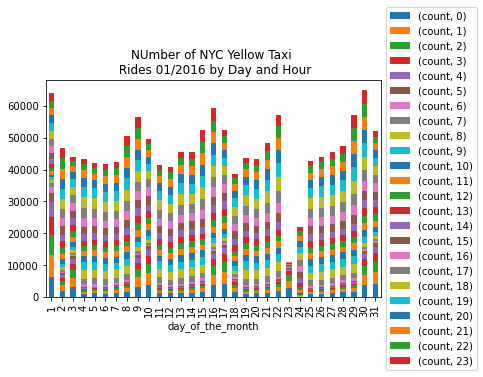

In [ ]:
df = tod_freq.to_pandas().set_index(['time_of_the_day', 'day_of_the_month']).unstack(level=0)
import matplotlib.pyplot as plt

f = plt.figure()

plt.title('NUmber of NYC Yellow Taxi \n Rides 01/2016 by Day and Hour', color='black')
df.plot(kind='bar', stacked=True, ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
tdf = gdf['count']
tdf['day_of_the_month'] = gdf['day_of_the_month']
tdf[[0, 1]].to_csv('two_days.csv')
tdf[[0, 1]].head(50)

time_of_the_day,0,1
0,6391.0,6824.0
1,2031.0,1661.0
2,3241.0,2795.0
3,1007.0,665.0
4,1226.0,772.0
5,1099.0,730.0
6,1305.0,892.0
7,1591.0,1089.0
8,3299.0,3064.0
9,3883.0,3549.0


In [ ]:
tdf = tdf.rename(columns={0: "0"})
tdf = tdf.rename(columns={1: "1"})

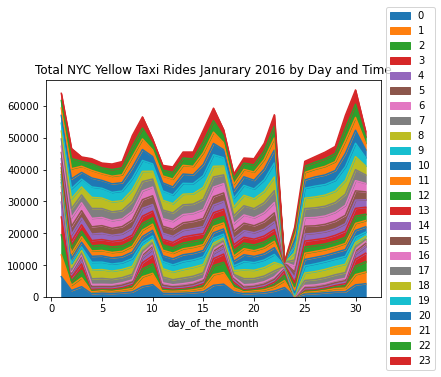

In [ ]:
df = tdf.to_pandas().set_index(['day_of_the_month'])
import matplotlib.pyplot as plt

f = plt.figure()

plt.title('Total NYC Yellow Taxi Rides Janurary 2016 by Day and Time', color='black')
df.plot(kind='area', stacked=True, ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
tddf = ddf['Trip_distance']
tddf['day_of_the_month'] = ddf['day_of_the_month']

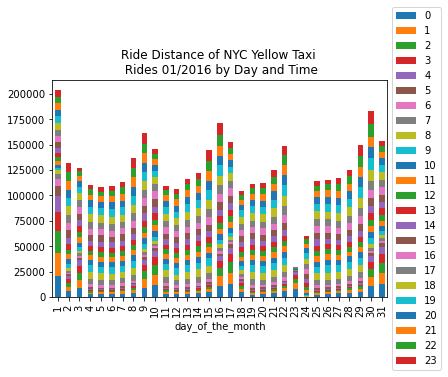

In [ ]:
df = tddf.to_pandas().set_index(['day_of_the_month'])
import matplotlib.pyplot as plt

f = plt.figure()


plt.title('Ride Distance of NYC Yellow Taxi \n Rides 01/2016 by Day and Time', color='black')
df.plot(kind='bar', stacked=True, ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

By far, the most "distance travelled" day is New Years day, high contributed to within the first 5 hours after the ball drops. 

## To be continued!

The other longer version of the notebook continues this analysis on a local GPU/private cloud instance with >24GB RAM available.  You can also download the taxi file for further analysis and import them into cudf as shown below:

In [ ]:
#download file
!wget https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2016-01.csv

In [ ]:
#import into cudf
df = cudf.read.csv("green_tripdata_2016-01.csv")